In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read in daily case data for US

In [9]:
dat = pd.read_csv("data/time_series_covid19_confirmed_US.csv")
dat.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,45,50,51,51,51,51,51,51,51,53


### Melt to long format, convert date to datetime

In [10]:
melted = pd.melt(dat, id_vars=["Admin2","Province_State"], value_vars = dat.columns[11:],
       var_name = "date", value_name = "confirmed_cases")
melted["date"] = pd.to_datetime(melted["date"])

In [12]:
melted.head(10)

,Admin2,Province_State,date,confirmed_cases
0,NaN,American Samoa,2020-01-22,0
1,NaN,Guam,2020-01-22,0
2,NaN,Northern Mariana Islands,2020-01-22,0
3,NaN,Puerto Rico,2020-01-22,0
4,NaN,Virgin Islands,2020-01-22,0
5,Autauga,Alabama,2020-01-22,0
6,Baldwin,Alabama,2020-01-22,0
7,Barbour,Alabama,2020-01-22,0
8,Bibb,Alabama,2020-01-22,0
9,Blount,Alabama,2020-01-22,0


## Cases by State

In [13]:
bystate = melted.groupby(["Province_State", "date"]).sum().reset_index()
bystate.head()

,Province_State,date,confirmed_cases
0,Alabama,2020-01-22,0
1,Alabama,2020-01-23,0
2,Alabama,2020-01-24,0
3,Alabama,2020-01-25,0
4,Alabama,2020-01-26,0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


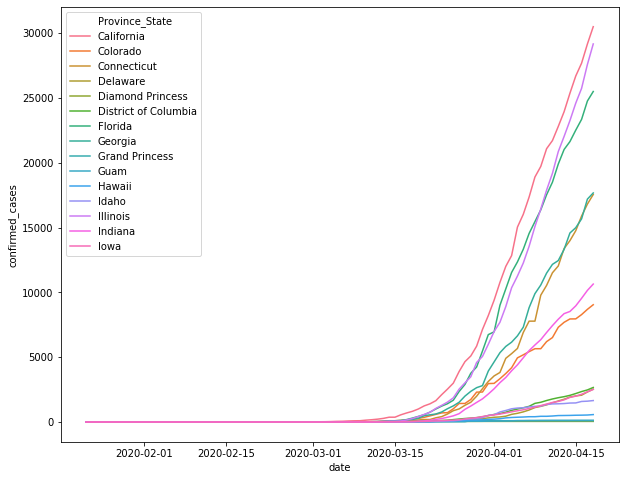

In [14]:
plt.figure(figsize=(10,8))
sns.lineplot(data = bystate[bystate["Province_State"].isin(bystate["Province_State"].unique()[5:20])], 
             x = "date", y = "confirmed_cases", hue = "Province_State")
plt.legend(loc = "upper left")
plt.show()

Group by month 

In [15]:
bystate_bymonth = bystate.groupby(["Province_State", bystate["date"].dt.month]).sum().reset_index()
bystate_bymonth.head()

,Province_State,date,confirmed_cases
0,Alabama,1,0
1,Alabama,2,0
2,Alabama,3,5942
3,Alabama,4,51436
4,Alaska,1,0


In [16]:
monthly_cases = pd.pivot_table(bystate_bymonth, index = "Province_State", columns = "date", 
                                 values = "confirmed_cases", aggfunc = np.sum ).reset_index()
monthly_cases.rename({1:"jan_cases", 2:"feb_cases", 3:"mar_cases", 4:"apr_cases"}, axis = 1, inplace = True)
monthly_cases.head()

date,Province_State,jan_cases,feb_cases,mar_cases,apr_cases
0,Alabama,0,0,5942,51436
1,Alaska,0,0,701,4205
2,American Samoa,0,0,0,0
3,Arizona,6,29,6783,56508
4,Arkansas,0,0,3721,20666


## Add additional features to states

Rates as of 4/18/2020:

*Hospitalization_Rate* - Total number of people hospitalized * 100/ Number of confirmed cases   
*Testing_Rate* - Total number of people tested per 100,000 persons  
*Incident_Rate* - confirmed cases per 100,000 persons  
*Mortality_Rate* - Number recorded deaths * 100/ Number confirmed cases  

In [17]:
rates_states = pd.read_csv("data/4.18states.csv")
rate_cols = ["Province_State", "Incident_Rate", "Testing_Rate", "Hospitalization_Rate", "Mortality_Rate"]
rates_states = rates_states[rate_cols]
bystate_bymonth = pd.merge(monthly_cases, rates_states, how = "left")
bystate_bymonth.head()

,Province_State,jan_cases,feb_cases,mar_cases,apr_cases,Incident_Rate,Testing_Rate,Hospitalization_Rate,Mortality_Rate
0,Alabama,0,0,5942,51436,100.492717,907.206961,13.157895,3.247029
1,Alaska,0,0,701,4205,52.530410,1615.226458,12.420382,2.866242
2,American Samoa,0,0,0,0,0.000000,5.391708,NaN,NaN
3,Arizona,6,29,6783,56508,64.901548,701.291175,11.981372,3.810330
4,Arkansas,0,0,3721,20666,67.361213,932.435235,16.685780,2.178899


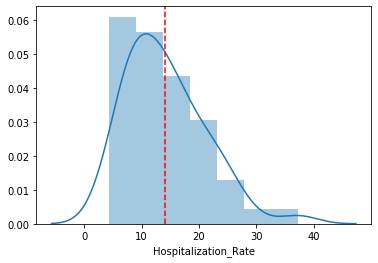

In [18]:
sns.distplot(bystate_bymonth.loc[~pd.isnull(bystate_bymonth["Hospitalization_Rate"]), "Hospitalization_Rate"])
plt.axvline(np.mean(bystate_bymonth["Hospitalization_Rate"]), color = "red", linestyle = "dashed")
plt.show()

Distribution of hospitalization rates is right skewed with mean around 12%

## PCA Clustering of States

In [19]:
state_features = bystate_bymonth.iloc[:,1:]
state_names = bystate_bymonth["Province_State"]


NAs inhibit svd in numpy package. Check how much data per feature we lose by omitting NAs.

In [20]:
state_features.isna().sum()

jan_cases                0
feb_cases                0
mar_cases                0
apr_cases                0
Incident_Rate            3
Testing_Rate             3
Hospitalization_Rate    10
Mortality_Rate           1
dtype: int64

In [25]:
n = state_features.shape[0]
rate_features = state_features.iloc[:,4:]
normalized_rfeatures = (rate_features - np.mean(rate_features, axis = 0)) / np.sqrt(n)
normalized_rfeatures = normalized_rfeatures.dropna()
u, s, vt = np.linalg.svd(normalized_rfeatures, full_matrices=False)

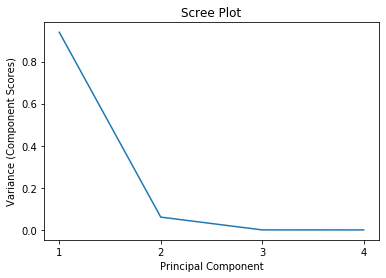

In [26]:
total_variance = sum(s**2)
two_dim_variance = sum(s[0:2]**2) / total_variance

plt.plot(np.arange(1, 5), s**2 / total_variance)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance (Component Scores)")
plt.xticks(np.arange(1, 5));

Looks like one PC is sufficient. Some value added by including PC2. Negligible information gained by adding more than 2 PCs.

In [28]:
(pd.DataFrame({"feature": rate_features.columns, 
               "PC1_Contrib":np.round(vt[0], 4),
               "PC2_Contrib":np.round(vt[1], 4)})
 .sort_values("PC1_Contrib", ascending = False))

,feature,PC1_Contrib,PC2_Contrib
1,Testing_Rate,0.9661,0.2580
0,Incident_Rate,0.2580,-0.9661
3,Mortality_Rate,0.0003,-0.0048
2,Hospitalization_Rate,-0.0029,-0.0085


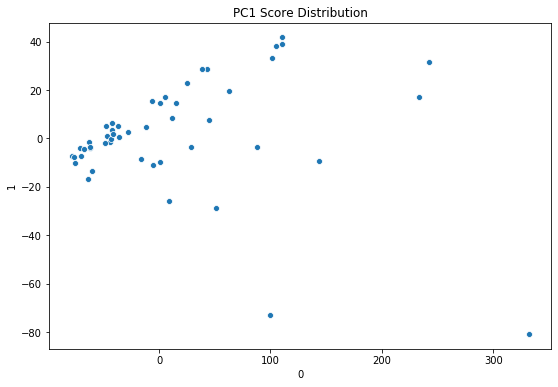

In [29]:
scores = normalized_rfeatures @ vt.T[:, 0:2]
plt.figure(figsize=(9, 6))
plt.title("PC1 Score Distribution")
plt.xlabel("PC1")
sns.scatterplot(scores[0], scores[1]);

In [30]:
scoredf = (pd.DataFrame({"State":state_names, "PC1score":scores[0], "PC2score":scores[1]})
 .sort_values("PC1score", ascending = False))
(pd.merge(scoredf, bystate_bymonth[["mar_cases", "apr_cases", "Province_State"]], 
          left_on = "State", right_on = "Province_State", how = "inner"))

,State,PC1score,PC2score,mar_cases,apr_cases,Province_State
0,New York,331.679765,-80.671501,464668,2952594,New York
1,Rhode Island,242.515885,31.576946,2566,37243,Rhode Island
2,Louisiana,233.317390,17.129295,28834,311417,Louisiana
3,Massachusetts,143.676409,-9.102445,34278,373325,Massachusetts
4,New Mexico,110.769776,38.981821,1847,18253,New Mexico
...,...,...,...,...,...,...
56,Nebraska,NaN,NaN,1158,11375,Nebraska
57,Nevada,NaN,NaN,6328,44604,Nevada
58,Northern Mariana Islands,NaN,NaN,2,182,Northern Mariana Islands
59,Puerto Rico,NaN,NaN,982,12673,Puerto Rico
